<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/15.UCB_P%3D20_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
P_max = 20 #in dBm

In [15]:
var = 20
number_of_cells = 4

In [16]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InReleas

In [17]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-10-28 03:34:32--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-10-28 03:34:33--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e72f310628b6d79903428a921.dl.dropboxusercontent.com/cd/0/inline/BY0qKwt64nOELdScIk6GXeJ4xBrWIQizxQvxp7F2rA_OrliExarnz6RVDD_TZazcY_T-Udr84NsRG5SThzN-pAuyX-6dEpGUgWFMMBxgMQsHvSDJ7QSKVbeggKpMZQGFfsDXaIw9-lfVYfNYjGuR2dRI/file# [following]
--2021-10-28 03:34:33--  https://uc0e72f310628b6d79903428a921.dl.d

In [18]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-10-28 03:34:39--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-10-28 03:34:39--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce38c91006a1b227d10457e4951.dl.dropboxusercontent.com/cd/0/inline/BY1T-vLlFdUkMFsNzux1cuqUglnHEwnKOgt_VV23q4A49uktv-JtSKO3iRWycKgF2AIPF8Q5qwVepA8a-SmSTk4P7wzMsKNZ20aFDhJMLdv9NufdGRJSFt-vrjSs38WKcy4TEXymSxmmRTNuhbxVtx8-/file# [following]
--2021-10-28 03:34:40--  https://uce38c91006a1b227d10457e4951.dl.dropboxusercontent.com/cd/0/inline/BY1T-vLlFdUkMFsNzux1cuqUglnHEwnKOgt_VV23q4A49uktv-JtSKO3iRWycKgF2AIPF8Q5qwVepA8a-SmSTk4P7wzMsKNZ20aFDhJML

In [19]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [22]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [23]:
def UCBobjective(Xsamples, X, model, beta):
  Xsamples = Xsamples[np.newaxis,:]
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = beta
  probs = mu + sigma * std
  return -probs[0]

In [24]:
#optimize the acquisition function
def opt_acquisition(X, y, model, iteration):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  if iteration<180:
   beta = 5*np.exp(((-6-np.log(5))*iteration)/180)
  else:
   beta = 5*np.exp(((-6-np.log(5))*180)/180)
  
  for i in range(1):
    result = dual_annealing(UCBobjective, bounds, args=(X,model,beta))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [25]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_P=20_3.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_P=20_3.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_P=20_3.npy")

x_next is [-20.33974916   0.31865257  13.07458526   6.37507528   9.31118504
  15.26547575  10.19381596  -8.39248447  15.22180803  -4.64700053
 -28.69614912   9.73113214   3.31780733  -5.6098375    2.00350762
  17.61433511 -14.75012856  12.82561487   6.26900094   9.46017388]
f()=50.751721, actual=36.444
0


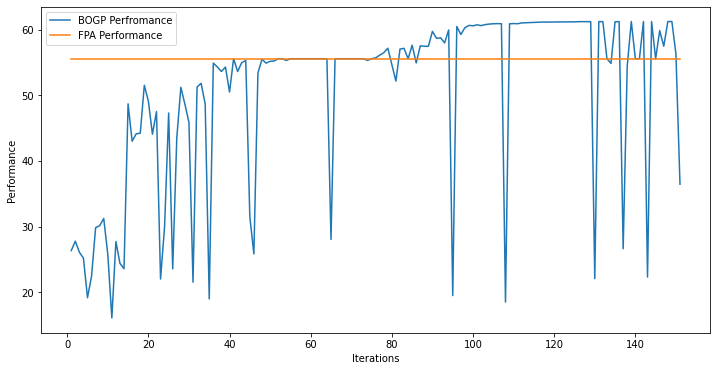

x_next is [ 19.99954616  19.99946911  19.99803603  13.43052341  19.99984979
  19.99974757  19.99953559 -30.99978404  19.99818846   9.29507068
 -30.99594728 -14.49362997  19.99958853  19.99937924  19.99966061
  19.99981502  19.99992878  19.99859437   8.94100854  19.8123693 ]
f()=59.773194, actual=59.391
1


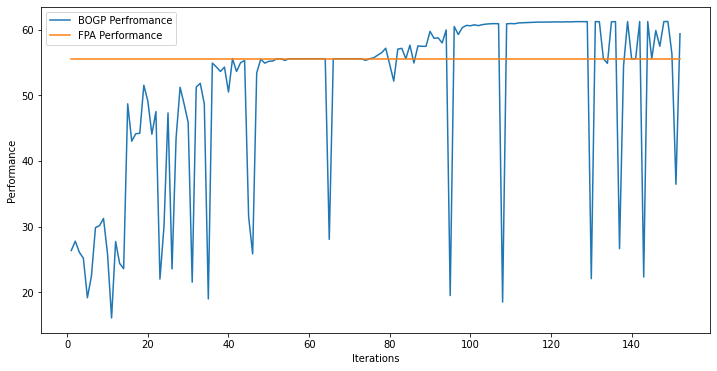

x_next is [ 19.99999779  19.99994616  19.94819727  13.3938126   19.99999577
  19.99886772  19.99995222 -30.8365679   19.99983971  10.10767909
 -30.92472282 -10.51056646  19.99999998  19.99985199  19.99999807
  19.99999869  19.9998508   19.99999982   9.78041659  19.87270568]
f()=59.445585, actual=59.448
2


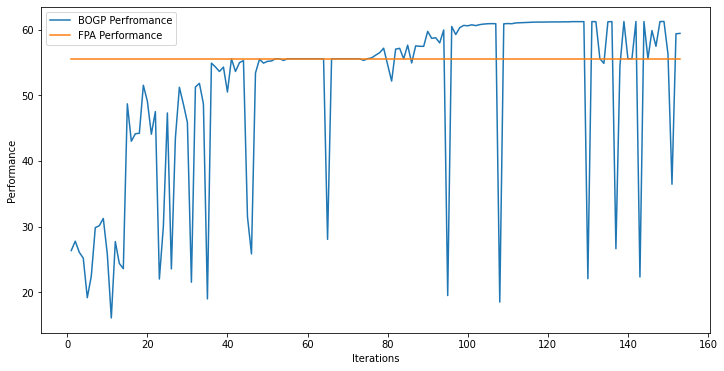

x_next is [ 19.99999998  19.99999994  19.9999973    8.84154144  19.99992842
  17.56528949  19.99999987  16.57163778  19.99999991   9.0465703
 -28.72801589  -0.44248482  19.99999996  19.99999996  19.99999999
  13.5464604   19.9999483   18.67969611  11.46792441  16.4659239 ]
f()=61.270357, actual=61.270
3


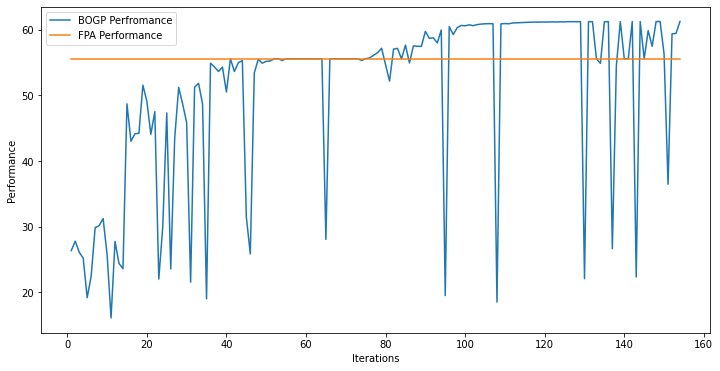

x_next is [ 19.99941938  19.99873369  19.98227109   8.8672399   19.99461866
  17.55269471  19.99613831  16.541436    19.9985913    9.06214386
 -28.76742413  -0.52155006  19.99726134  19.99948167  19.99562129
  13.5327753   19.99589346  18.66374375  11.45557031  16.41988907]
f()=61.267465, actual=61.265
4


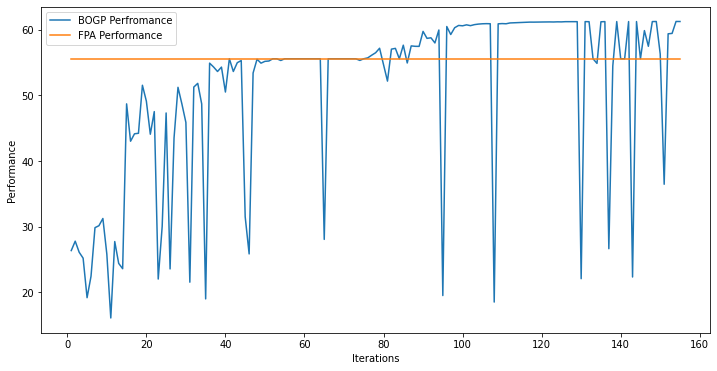

x_next is [ 19.99919295  19.99874952  19.9985639    8.76772046  19.96755003
  17.47638488  19.99748805  16.6861375   19.99652633   9.09269083
 -28.59484789  -0.122133    19.99715299  19.99708303  19.99658275
  13.56925211  19.99683184  18.65098912  11.44794292  16.6252911 ]
f()=61.272112, actual=61.275
5


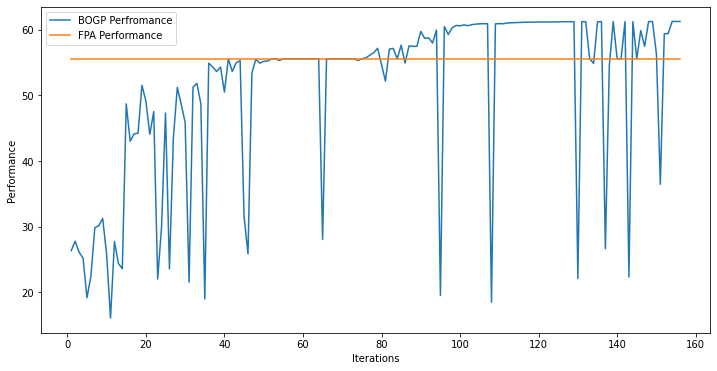

x_next is [ 11.14379137 -19.09597362 -17.62973903  13.84056729  19.99985815
  19.99991841   5.50800292  19.99994453  -5.5221127   19.99999818
  -2.92500864  19.99994856  19.9997529   19.9995859   19.99997417
  19.99982003  19.99980685  19.99990254   9.19660537  19.99991276]
f()=60.431031, actual=54.139
6


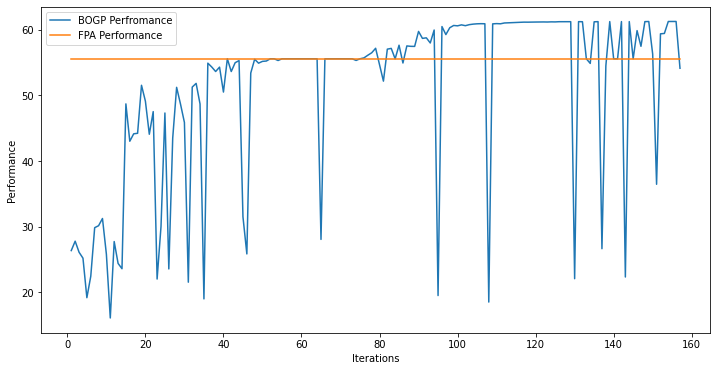

x_next is [ 2.00000000e+01  2.00000000e+01  2.00000000e+01  8.88303930e+00
  1.97674032e+01  1.74391310e+01  2.00000000e+01  1.67756039e+01
  2.00000000e+01  9.10379279e+00 -2.84806927e+01  2.19563887e-03
  2.00000000e+01  1.99999999e+01  2.00000000e+01  1.35146866e+01
  2.00000000e+01  1.85896911e+01  1.13279890e+01  1.66386437e+01]
f()=61.277091, actual=61.272
7


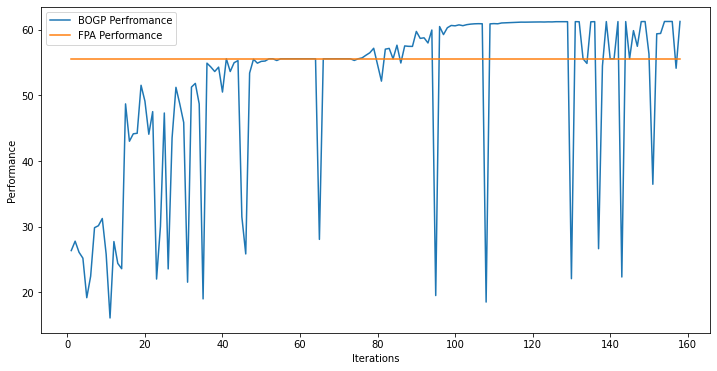

x_next is [ 19.99941634  19.99951885  19.99810695   8.75406699  19.98100351
  17.33561319  19.99051064  16.75840741  19.99649695   9.15305606
 -28.51874917  -0.13458684  19.99920065  19.99935883  19.99828552
  13.60120701  19.99180472  18.5745555   11.52232288  16.64011935]
f()=61.274664, actual=61.274
8


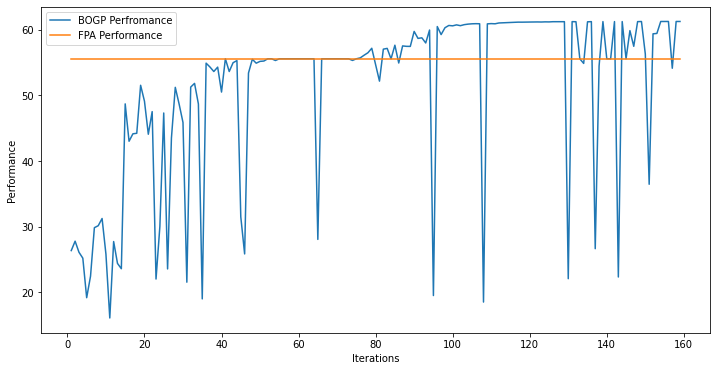

x_next is [ 19.99995496  19.99895066  19.99707569   8.58586316  19.98488386
  17.443762    19.99811085  16.72973083  19.99784628   9.08432416
 -28.71557457   0.03370471  19.99875206  19.99753405  19.99764051
  13.53768742  19.99722054  18.63935133  11.47828705  16.57173039]
f()=61.275695, actual=61.280
9


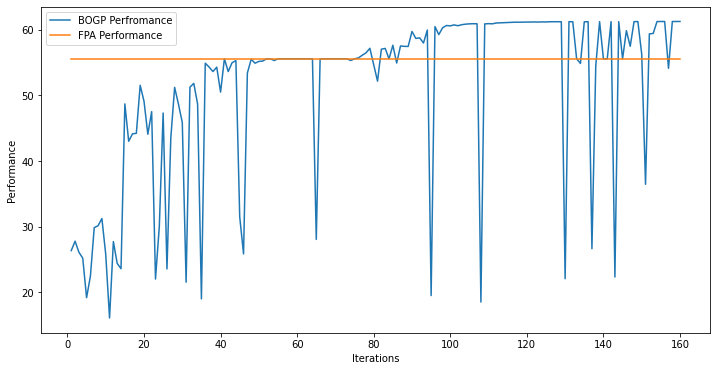

x_next is [-29.5080121    6.94183261  17.12238418  -7.4975272    3.24433368
 -27.00505448 -28.80271531  18.22329208  -2.67966734  17.51155769
 -18.56896045  19.25907826 -29.62439029  14.16622648   8.134596
 -29.64365024 -30.95995932  -4.49300077   1.82537005 -27.06086131]
f()=51.187066, actual=22.902
10


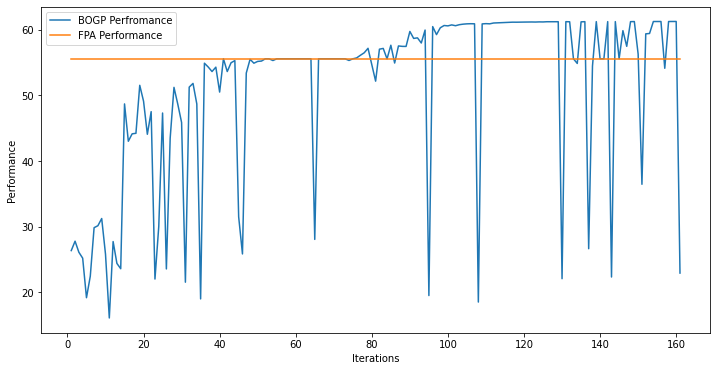

x_next is [ 19.99993568  19.99904897  19.99581343   8.45564846  19.99728044
  17.37696316  19.99633656  16.77882575  19.99994911   9.14280376
 -28.74834993   0.08588052  19.99936069  19.9994399   19.99865196
  13.49957405  19.99818371  18.64694213  11.45070233  16.49425676]
f()=61.281325, actual=61.283
11


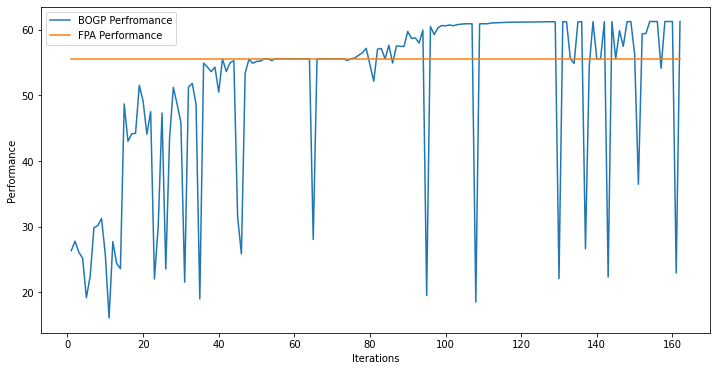

x_next is [ 19.99999576  19.99999791  19.99999806  13.66413912  19.99818764
  19.99999839  19.99999821 -30.98767452  19.99999894  10.2024264
 -30.99997211 -10.02567437  19.99890234  19.9999974   19.99999789
  19.97493415  19.99999297  19.99896596   9.18009103  19.9999966 ]
f()=59.452832, actual=59.469
12


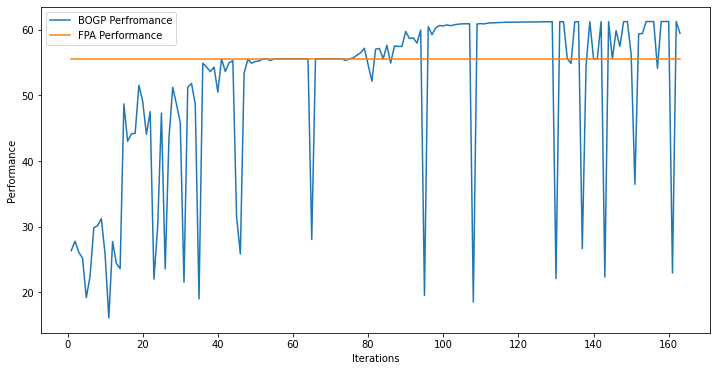

x_next is [ 19.9998486   19.99995345  20.          19.99989835  19.99972454
  20.          20.          19.99982758  19.99965458  19.99999643
 -30.99999671  19.99983198  20.          19.99997955  19.99992122
  19.99999289  19.99999076  19.99993001  20.          19.99999205]
f()=51.126051, actual=55.584
13


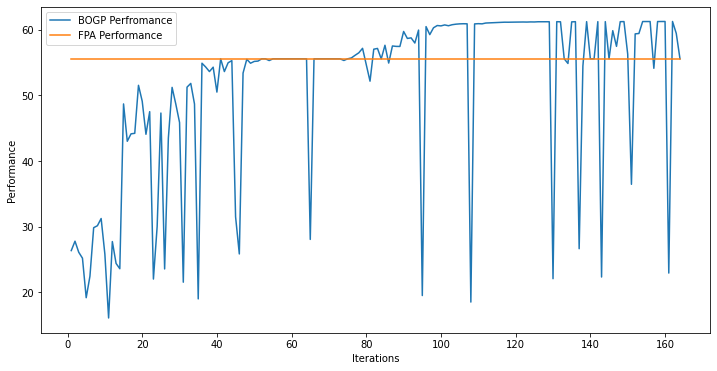

x_next is [ 19.99999977  19.99999965  19.99999958   8.37110588  19.9858959
  17.34134015  19.99301908  16.80818049  19.99999976   9.19748596
 -28.80794796   0.06216902  19.99999967  19.99999988  19.99999968
  13.47791571  19.99949207  18.67293709  11.28525028  16.41254293]
f()=61.283905, actual=61.283
14


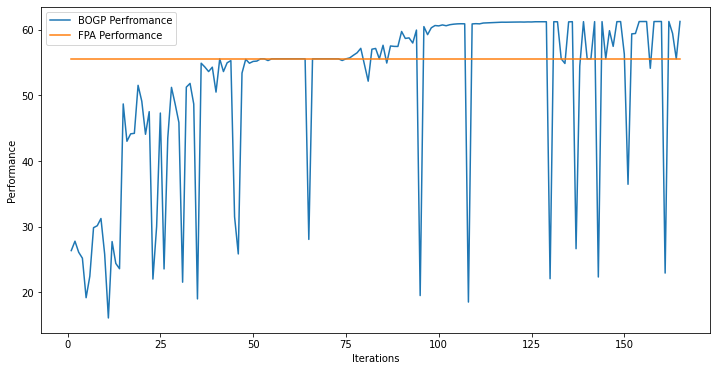

x_next is [ 20.          19.99999999  20.           8.33039349  19.94941937
  17.42645695  19.99999998  16.8265027   20.           9.17744587
 -28.72663118   0.15167503  20.          20.          20.
  13.40671468  19.99657692  18.59033641  11.43828339  16.40781788]
f()=61.283966, actual=61.284
15


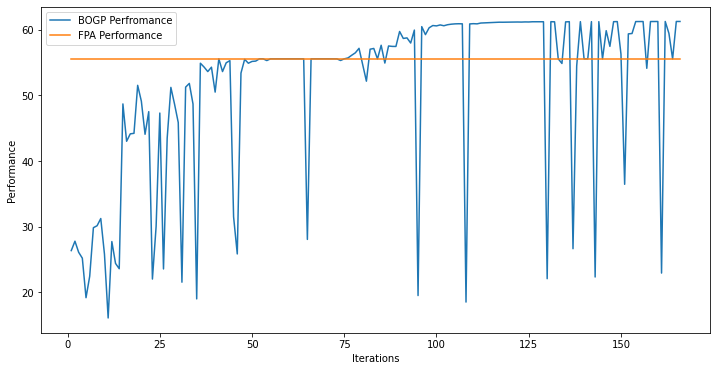

x_next is [ 19.99892484  19.98730818  19.97924426   8.27660553  19.95470987
  17.45569326  19.99946906  16.84048409  19.99625915   9.13452009
 -28.71541293   0.11899328  19.99550356  19.99278058  19.99720333
  13.42480363  19.99460791  18.56181892  11.3156321   16.470368  ]
f()=61.278388, actual=61.275
16


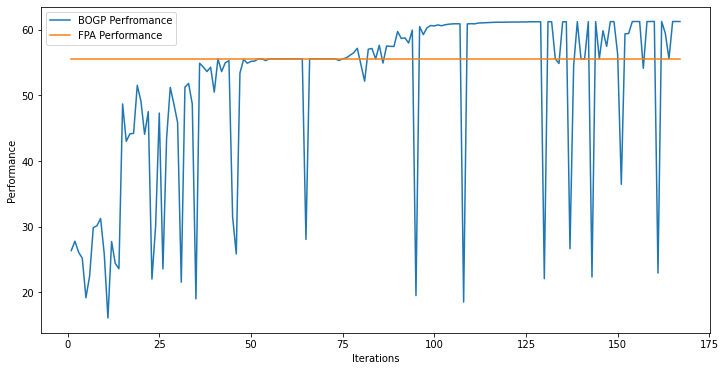

x_next is [ 19.77525174  19.66903282  19.12116053   6.85556446  19.41439195
  17.29550329  19.93087915  17.23844449  19.56407846   9.90483867
 -29.56247965   0.49532771  19.37127019  19.98177555  19.98740803
  14.62010122  19.1911367   17.40376694   9.68766871  15.84023909]
f()=60.815525, actual=60.611
17


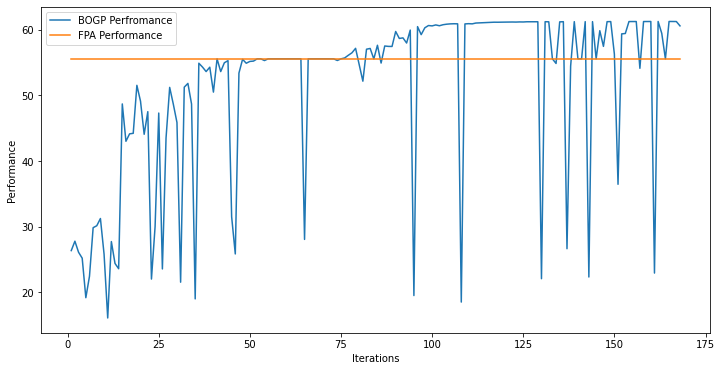

x_next is [ 19.99454232  19.93914563  19.98450869   8.34958781  19.83489424
  17.2397234   19.94379662  16.9983763   19.97925871   9.36575827
 -28.66749461  -0.09096452  19.9826864   19.98322359  19.96879529
  12.9898154   19.99414471  18.53678267  11.5269309   16.66085358]
f()=61.249977, actual=61.245
18


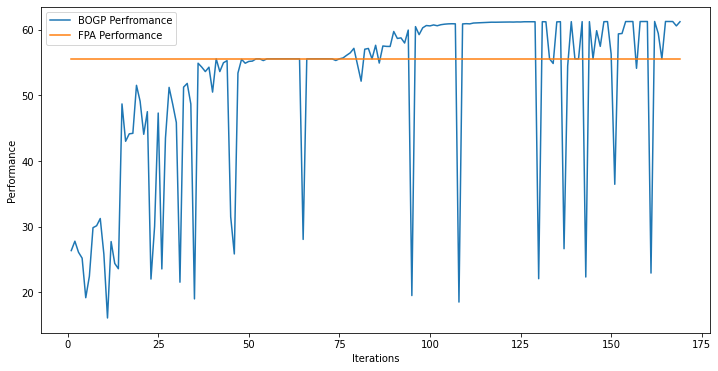

x_next is [ 19.9999766   19.99996384  19.99999096  19.99993909  19.99995795
  19.99996445  19.9998845   19.99995341  19.99998748  19.99994451
 -30.9999588   19.99964146  19.99975433  19.99977895  19.99987883
  19.99999019  19.99995228  19.9999756   19.99985051  19.99978951]
f()=51.449033, actual=55.584
19


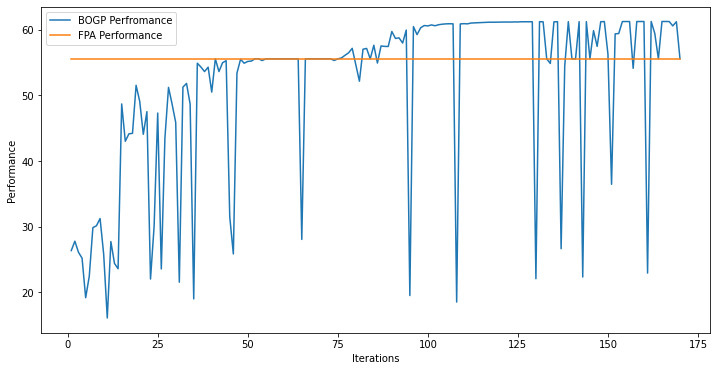

x_next is [ 13.96966352   8.74809486 -10.81749605 -11.0124583   19.56297166
  14.34460006 -23.0767714   -0.49171272  13.09688132   1.76139003
   8.70522063 -18.56972856   7.79053401 -19.03897017  -4.23289637
 -25.3030213  -20.53109254 -10.78940925  -8.61668086  11.82778523]
f()=29.408613, actual=29.108
20


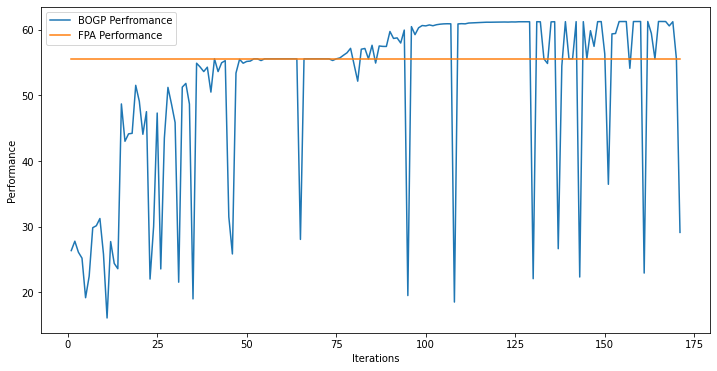

x_next is [ 19.99677794  19.99994573  19.99834976  14.59971057  19.99647534
  19.99200987  19.99607343 -30.9390765   19.99945721   8.98858635
 -30.96001409  -9.02421818  19.99701077  19.99564345  19.99949569
  19.99543693  19.98901822  19.98583083   7.6967653   19.99838998]
f()=59.489350, actual=59.320
21


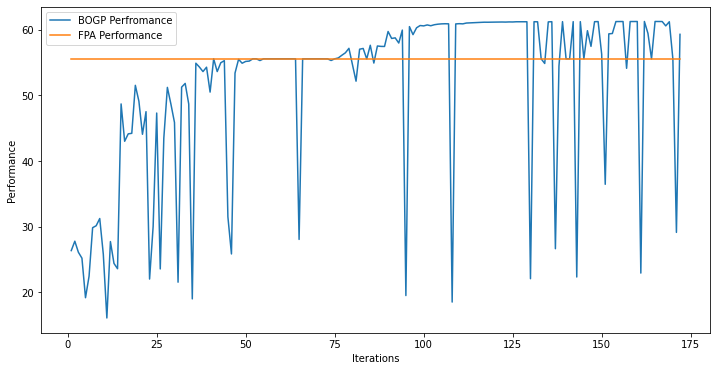

x_next is [ 19.99739234  19.99760014  19.9991292    8.47153417  19.98169989
  17.24841796  19.99919711  16.86026412  19.99870982   9.20180952
 -28.73250142   0.22607543  19.99885003  19.99905317  19.99982229
  13.13689184  19.99504395  18.71603151  11.48590176  16.26127763]
f()=61.286483, actual=61.296
22


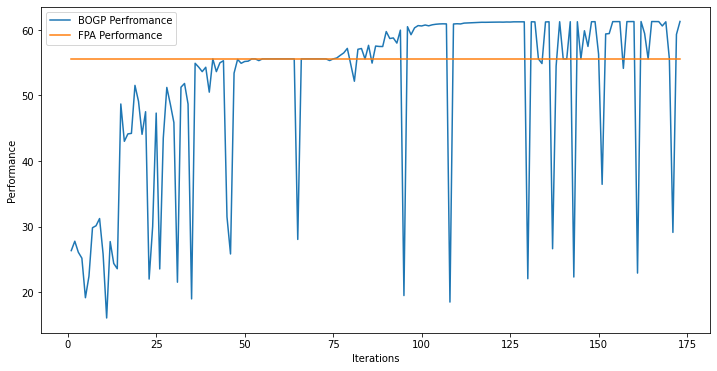

x_next is [ 19.99829638  19.99684044  19.99120235  13.11760474  19.99416837
  19.99572454  19.99791129 -30.99686631  19.98773795  16.13062097
 -30.99966946 -12.51091622  19.99653165  19.99822159  19.99954132
  19.83322138  19.98511151  19.9961207    8.20650069  19.99569921]
f()=59.708640, actual=58.429
23


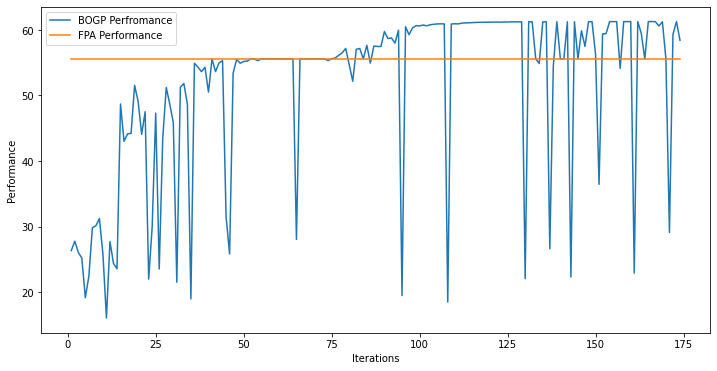

x_next is [ 19.99999002  19.99958694  19.99736485   8.57971346  19.99997822
  17.20211615  19.99698047  16.99278252  19.99732271   9.11644839
 -28.64462562   0.44075791  19.99962834  19.99823261  19.99989931
  13.02986074  19.99823486  18.76167124  11.50828989  16.02507209]
f()=61.300252, actual=61.298
24


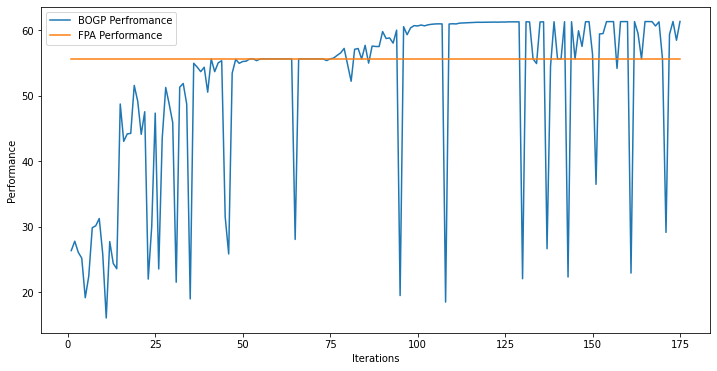

x_next is [ 19.99983143  19.99918818  19.99974908   5.76173661  19.99820414
  19.999436    19.99921162 -30.99992419  19.99999446   3.40241755
 -30.9997826  -12.25792042  19.99983281  19.99977274  19.9996215
  17.10867122  19.99894396  19.99914747  13.10527738  19.99919179]
f()=59.949263, actual=57.586
25


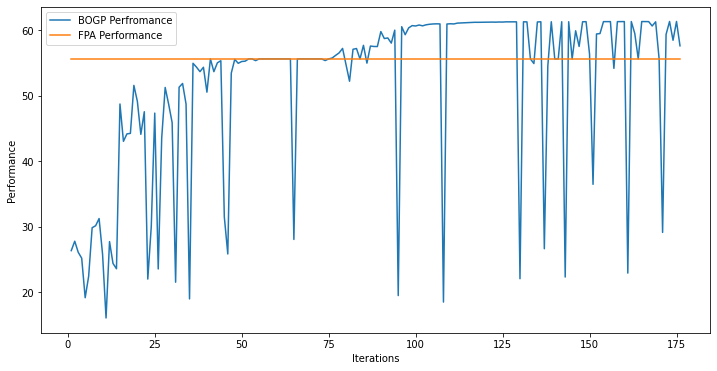

x_next is [  9.81720376 -27.47822961 -22.14665373  16.7187366   18.89932187
  19.53658912  -6.05906958  14.80044285   9.60214658   0.88548837
  -0.84211762  19.80176403   1.71894432  -4.11746942  18.14001132
  13.79793854  16.09515142  15.94229645  12.11772617  17.56956869]
f()=45.797035, actual=48.213
26


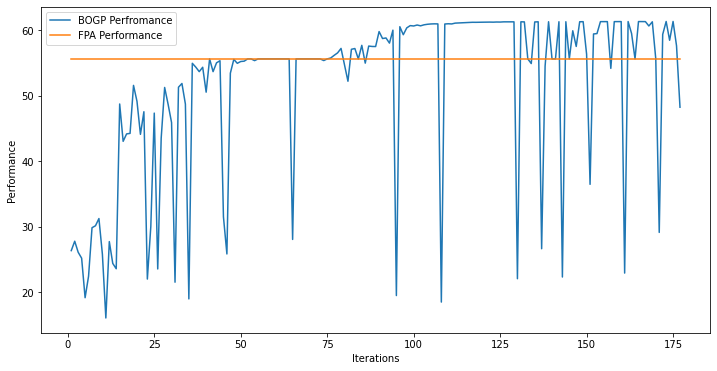

x_next is [ 19.99963897  19.99777063  19.99830463   8.53517053  19.99710159
  17.23986191  19.99981559  16.89926945  19.9998556    9.13465764
 -28.71805546   0.34219049  19.99862006  19.99981234  19.99903317
  13.0500297   19.99773347  18.78711747  11.50866243  16.13145779]
f()=61.298523, actual=61.299
27


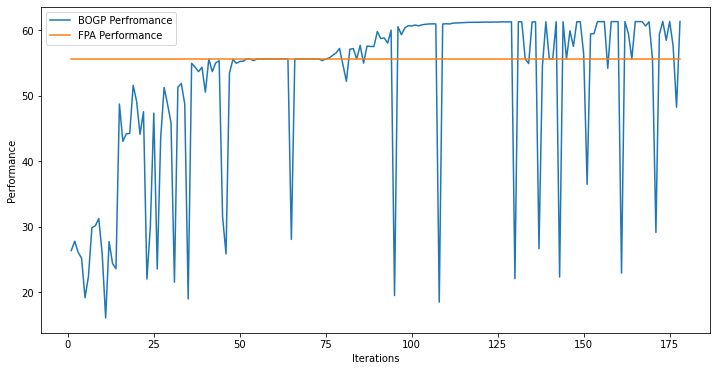

x_next is [ 19.99999906  20.          19.99982001   8.56495821  19.9999999
  17.25145016  19.99999994  16.89536293  19.9999999    9.13226098
 -28.72855522   0.3407334   19.99999997  19.99999996  19.99999999
  13.02081835  19.99980674  18.80551272  11.51747653  16.14635373]
f()=61.299825, actual=61.300
28


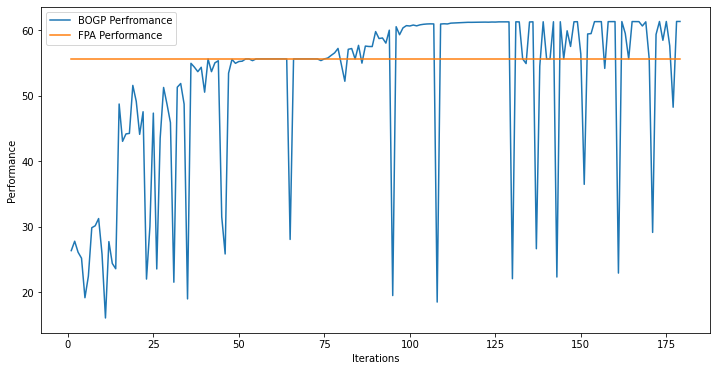

x_next is [ 19.99980942 -30.9996846  -23.92145137  19.32882506  19.9994425
  19.99975383  10.6827718   19.99989962  11.50728031  15.45880535
   2.1439258   19.99971877  19.99997611  19.99945723  19.99995777
  19.99930268  19.99931215  19.999831    18.10625385  19.99960929]
f()=55.588245, actual=55.802
29


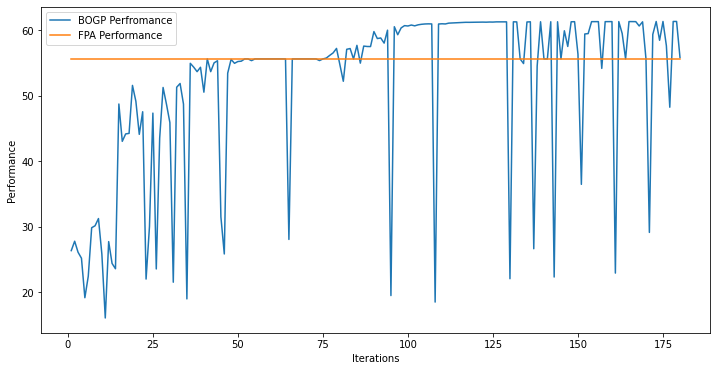

x_next is [ 19.99955649  19.99986713  19.99659001   8.565299    19.99976161
  17.23534075  19.99998388  16.8946581   19.99850421   9.10628042
 -28.77071719   0.36211574  19.99938476  19.99979357  19.99961059
  12.99897315  19.99761709  18.79719427  11.52654744  16.13693713]
f()=61.298987, actual=61.300
30


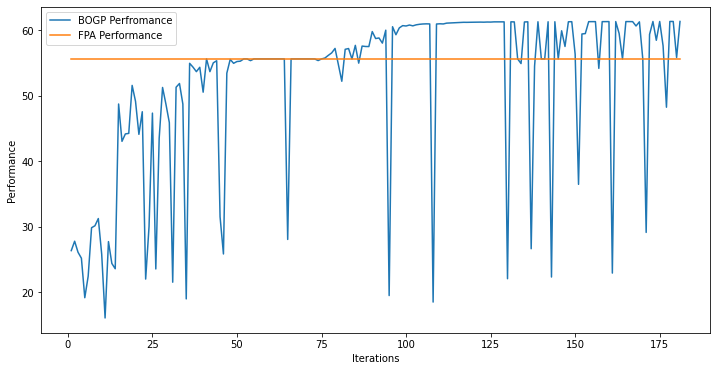

x_next is [-13.18423571  15.64137197 -23.66738919 -24.92279284  -9.41495966
  12.42528942  -7.99394111   8.43722213 -11.78054913   8.67257915
  15.28670714 -18.74394565  10.10579671  11.14977005  -1.93960717
  -9.58388877 -12.8669791  -26.76056794  11.79325106 -30.27182823]
f()=25.629395, actual=25.588
31


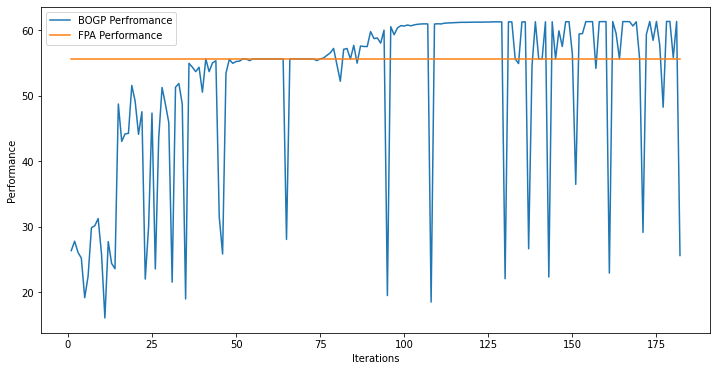

x_next is [ 19.99994606  19.9993145   19.99947115   8.51220359  19.99595944
  17.19022254  19.99963067  16.89972245  19.99968134   9.01216427
 -28.87741702   0.38632951  19.99957069  19.99946689  19.99983127
  12.9565564   19.99792306  18.71154996  11.55217057  16.10947229]
f()=61.300580, actual=61.301
32


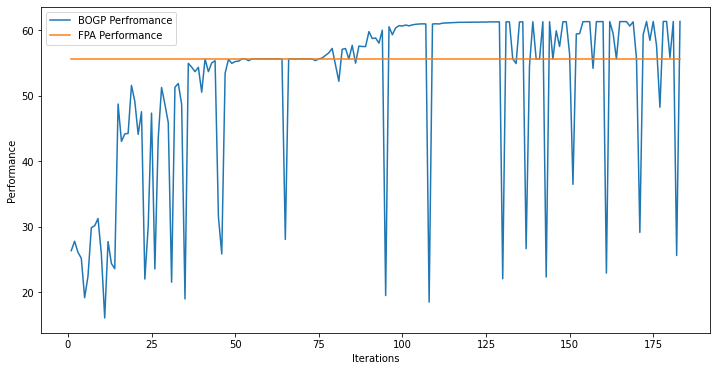

x_next is [ 19.9994448   19.99966357  19.99805126   8.54357471  19.99993972
  17.12977193  19.99981162  16.91659699  19.9989314    8.99031458
 -28.91048135   0.34542952  19.99956481  19.99962147  19.99965186
  12.94315705  19.99653646  18.71415171  11.59597684  16.07592239]
f()=61.300921, actual=61.299
33


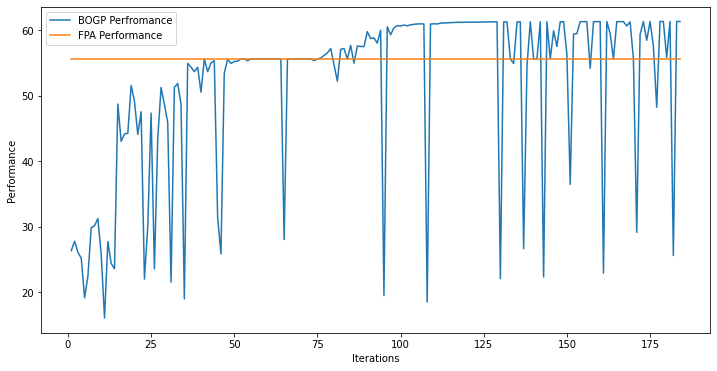

x_next is [  7.72550762 -22.1764625    5.41874982   7.65208569 -29.48983873
 -19.40409595  -9.26924763 -15.59716729  -2.51293724  15.57454516
 -28.11054456 -12.2799831  -13.41443104 -26.9359191  -18.27387458
 -17.59425952  19.4112391   -6.78380781 -24.96612784  16.64674987]
f()=51.704735, actual=25.267
34


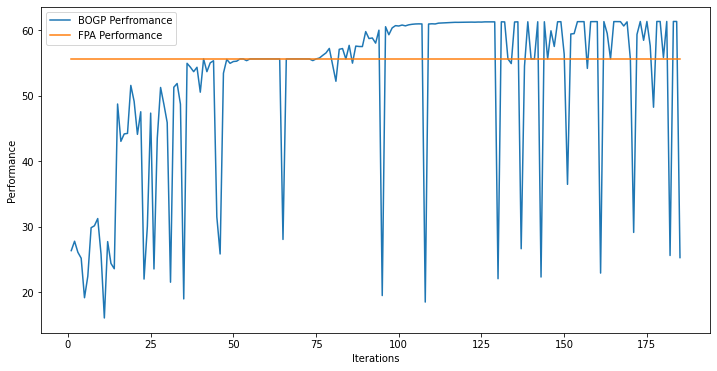

x_next is [ 20.          20.          20.           8.50496966  19.9973762
  17.22997788  19.99965354  16.85323818  19.99533634   9.0764195
 -28.92707527   0.47405223  19.99793875  19.99999999  20.
  12.95490425  19.99743207  18.68840984  11.5106885   16.20494934]
f()=61.301604, actual=61.303
35


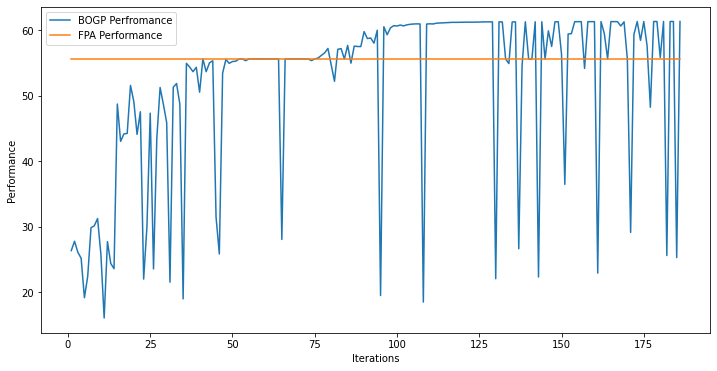

x_next is [ 19.99818274  20.          19.99999899   8.50785317  20.
  17.23095938  19.99999999  16.79757061  19.99926555   9.13499455
 -28.95878239   0.65418542  20.          19.99999999  20.
  12.90876756  19.9991922   18.6472865   11.50157042  16.18365458]
f()=61.305309, actual=61.308
36


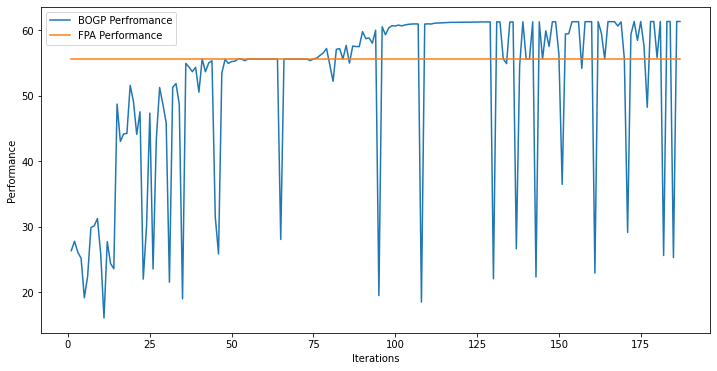

x_next is [ 19.99999997  19.99999999  19.99999999   8.47852298  19.99999992
  17.2092247   19.99998323  16.59582611  19.99996641   9.19937287
 -28.91449247   0.87332734  19.99997119  19.99999999  20.
  12.83991348  19.99998412  18.54495549  11.56226671  16.06621406]
f()=61.312173, actual=61.313
37


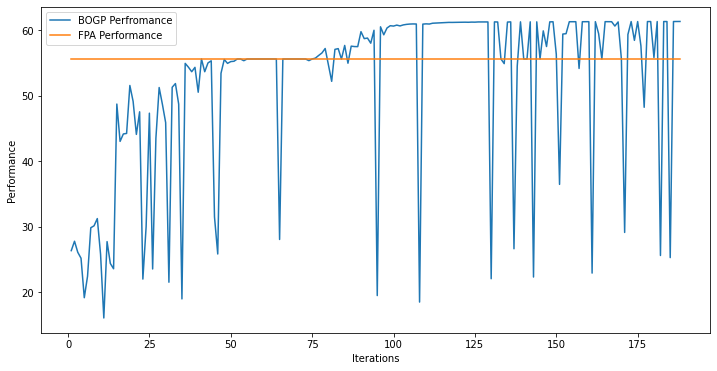

x_next is [ 19.99988357  19.99969849  19.99975368   8.4995834   19.99586182
  17.21280793  19.99965361  16.58350135  19.99983362   9.1993275
 -28.88352263   0.90286393  19.99997168  19.9999796   19.99969955
  12.87708863  19.99541405  18.51370035  11.59847307  16.02218998]
f()=61.311941, actual=61.311
38


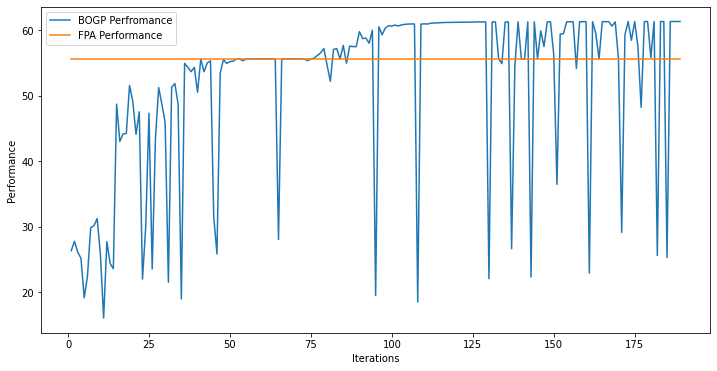

x_next is [ 19.99897369  19.99888293  19.99905984   8.46662216  19.99907488
  17.19493791  19.99632792  16.53298262  19.99784273   9.2123887
 -28.96534586   0.90335468  19.99977835  19.9990596   19.99944426
  12.77374624  19.99964329  18.59142766  11.51031677  16.1288605 ]
f()=61.311786, actual=61.314
39


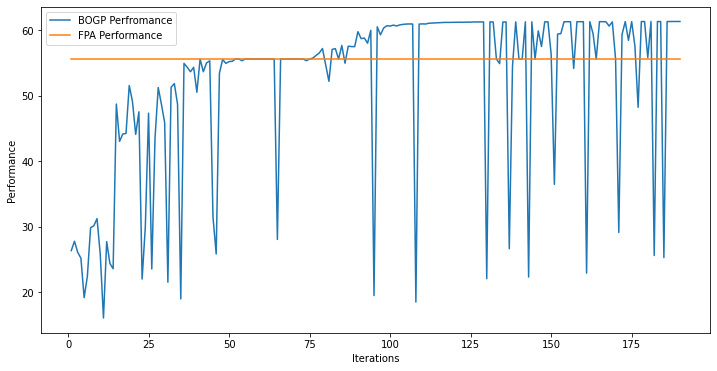

x_next is [ 19.99999999  19.99999999  19.99811067   8.40649218  19.99793416
  17.12509945  19.99999999  16.43448569  19.99999998   9.14589408
 -28.96628949   1.02740067  19.99999999  19.99999999  20.
  12.7348616   19.99890541  18.70866657  11.46863484  16.16572747]
f()=61.316969, actual=61.321
40


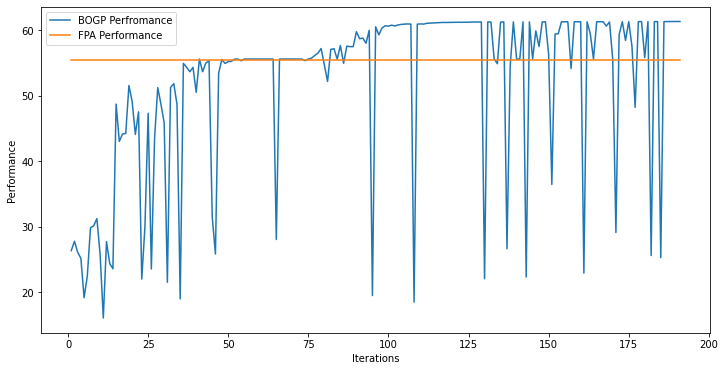

x_next is [ 19.99945441  19.99921541  19.9998156   19.81980312  19.99863601
  19.99907383  19.99850274 -30.99959406  19.99992164   8.19457329
 -30.99985979 -13.22069281  19.99893404  19.99903999  19.99949507
  19.99818601  19.99890299  19.99959502  13.114715    19.99882061]
f()=59.812524, actual=58.375
41


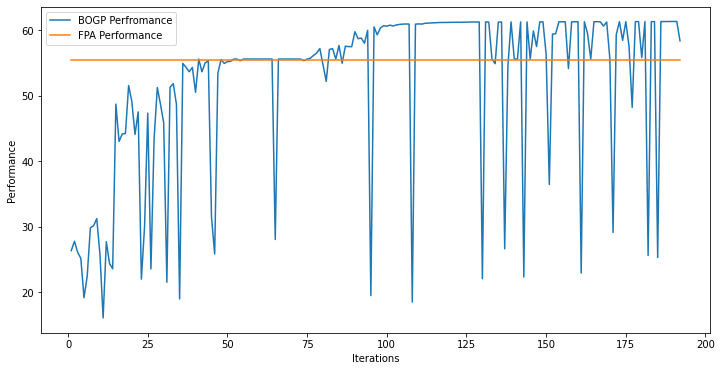

x_next is [ 19.99905654  19.99691199  19.99688279   8.22246862  19.99557855
  16.94406423  19.9996163   16.32670824  19.99946726   9.07855925
 -28.87125242   1.29918477  19.99816037  19.99979079  19.99981608
  12.73989438  19.99232611  18.90727591  11.56522802  16.1591168 ]
f()=61.323052, actual=61.326
42


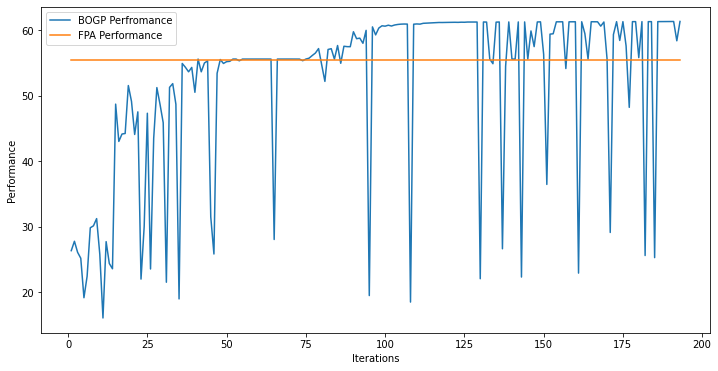

x_next is [ 19.99868326  19.99999992  19.99868576   8.16970068  19.999155
  16.91314759  19.99665804  16.35173619  19.99999552   9.02217375
 -28.84477548   1.29056407  19.99999991  19.99832161  19.99999995
  12.69918474  19.99129216  18.92196254  11.60995868  16.10518122]
f()=61.327011, actual=61.327
43


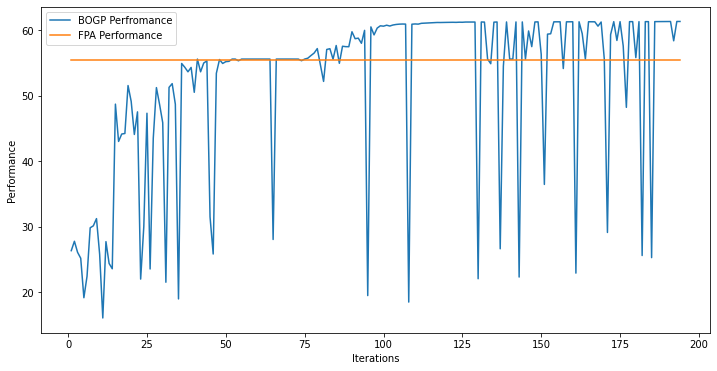

x_next is [ 19.99974414  19.9993266   19.99922839   8.14223275  19.99596573
  16.95709293  19.99988009  16.33759765  19.99999381   9.01616772
 -28.82733493   1.33491021  19.99849623  19.99579007  19.99913861
  12.68872541  19.98717369  18.93992014  11.61142475  16.11468804]
f()=61.326530, actual=61.328
44


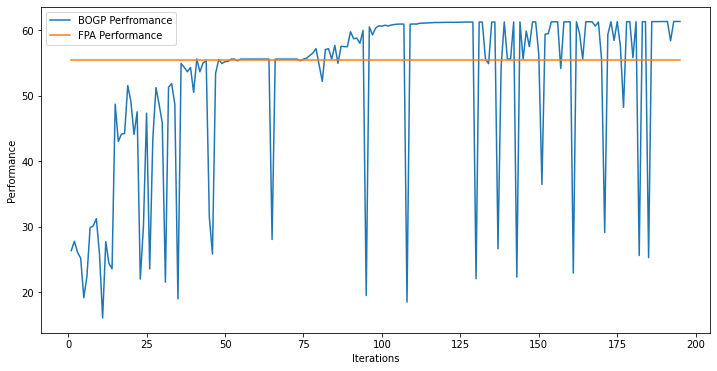

x_next is [ 20.          19.99999998  19.99999997   8.06413167  19.99956814
  17.20636362  20.          16.3308596   19.99975008   9.02690603
 -28.78404771   1.5418461   19.99999999  19.99999999  20.
  12.61942413  19.99810007  19.02670997  11.68603296  16.06759181]
f()=61.333134, actual=61.335
45


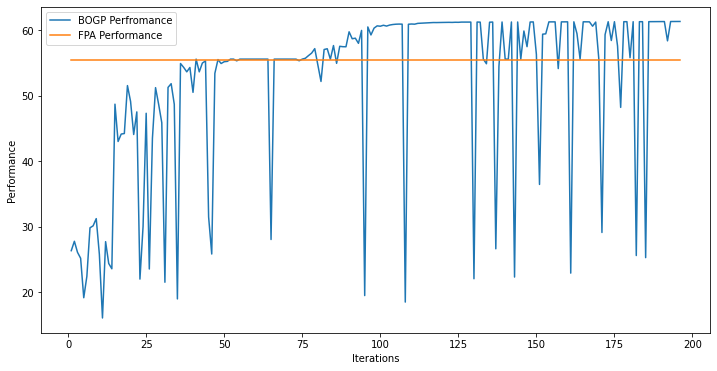

x_next is [ 19.99911762 -30.99781864 -25.77554201  17.98032833  19.99967973
  19.99815082  12.45847618  19.99713299  13.87006475  15.87373013
   1.26741595  19.99906704  19.9996179   19.99974465  19.99970801
  19.99902371  19.9988923   19.99938605  17.7790802   19.99943006]
f()=55.814874, actual=56.454
46


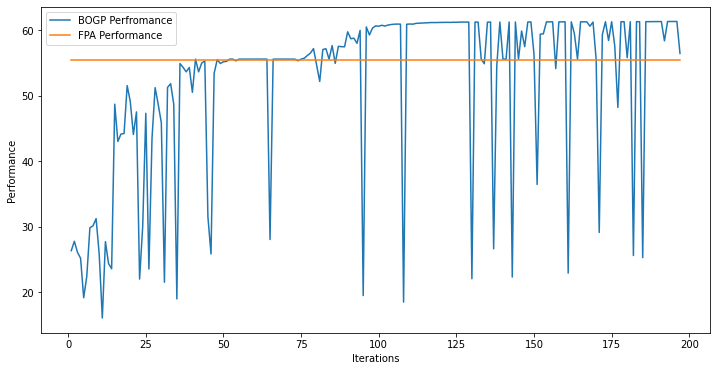

x_next is [ 19.99987939 -30.99987747 -30.99944232   5.06689271  19.99997363
  19.99970224  19.99876036  19.99980762  19.99869479  19.99392015
  -4.35725586  19.99961598  19.99983318  19.99970962  19.99943578
  19.99929379  19.99976085  19.99964688  14.55349417  19.99866689]
f()=58.186638, actual=56.088
47


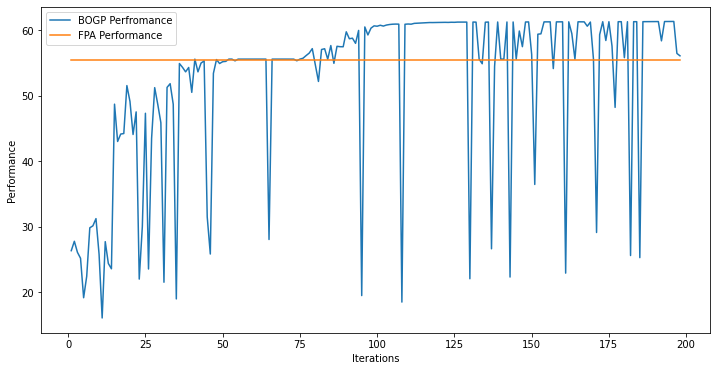

x_next is [ 19.99740005  19.99850831  19.99907812   8.045846    19.98668052
  17.19045349  19.99893466  16.33997543  19.99662816   9.04330231
 -28.78419022   1.58760147  19.99715035  19.99877591  19.99974552
  12.61410075  19.99304016  19.06309652  11.66434371  16.01457125]
f()=61.333047, actual=61.335
48


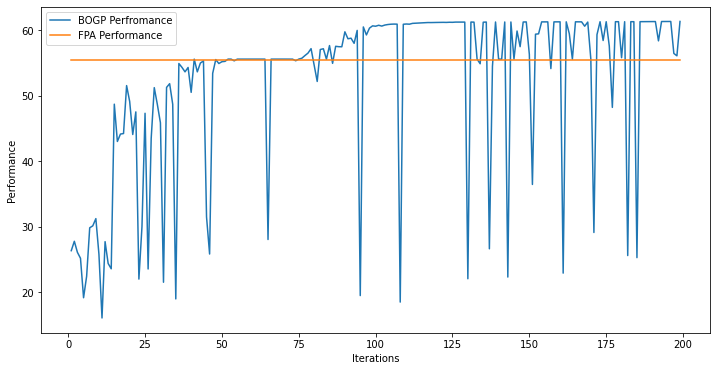

x_next is [ 19.99717805  19.99951235  19.99928586   8.00346282  19.99707407
  17.23265225  19.99983412  16.41411532  19.99923836   9.06361041
 -28.85511941   1.87509416  19.99815933  19.99758493  19.9994789
  12.55402683  19.99803612  19.24062122  11.5155067   15.71539727]
f()=61.341822, actual=61.344
49


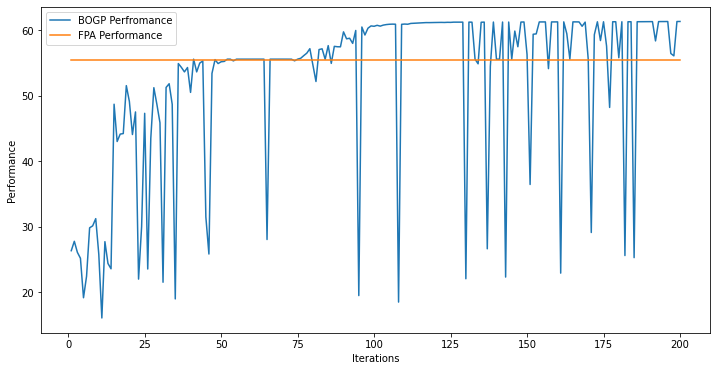

In [28]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

#X = 0 * np.ones([1,var], dtype = "float")
#y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

#tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
#y_FPA = np.array([[tr_FPA]])

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(50):
  x_next = opt_acquisition(X, y, model, X.shape[0]+1)

  np.save("/content/drive/MyDrive/trainingx_BOGP_P=20_3.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_P=20_3.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_P=20_3.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)
  
  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()


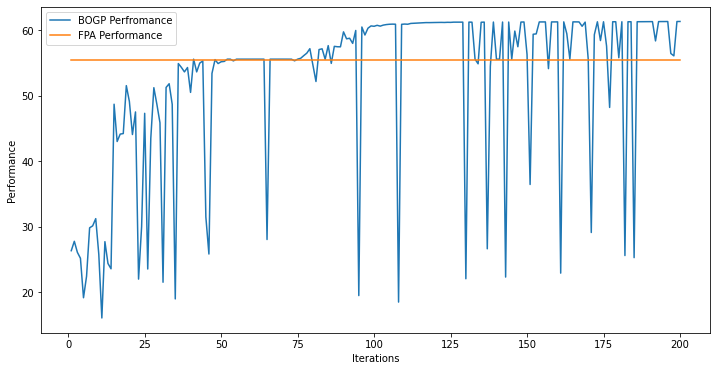

P_max = 20.000, Optimal_SE = 61.344
P_max = 20.000, Optimal_SE_FPA = 55.514


In [29]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

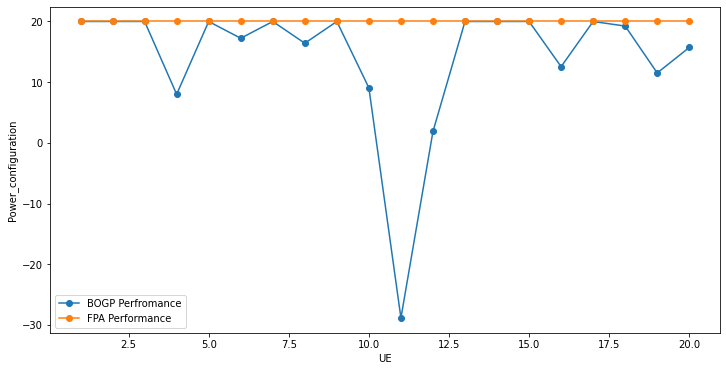

Power_configuration_BOGP is [ 19.99717805  19.99951235  19.99928586   8.00346282  19.99707407
  17.23265225  19.99983412  16.41411532  19.99923836   9.06361041
 -28.85511941   1.87509416  19.99815933  19.99758493  19.9994789
  12.55402683  19.99803612  19.24062122  11.5155067   15.71539727]


In [30]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:], '-o')
pyplot.plot(np.arange(1,21),X_FPA[:], '-o')
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

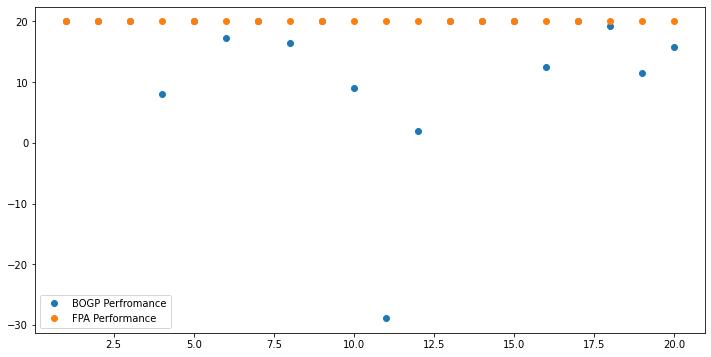

Power_configuration_BOGP is [ 19.99717805  19.99951235  19.99928586   8.00346282  19.99707407
  17.23265225  19.99983412  16.41411532  19.99923836   9.06361041
 -28.85511941   1.87509416  19.99815933  19.99758493  19.9994789
  12.55402683  19.99803612  19.24062122  11.5155067   15.71539727]


In [31]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])